# btlflt.ipynb

There is much interest in using insect wimgbeat waveforms for automated monitoring of insect flight activity. [Perform a Google search for "insect wingbeat waveform"](https://www.google.com/search?client=ubuntu&channel=fs&q=insect+wingbeat+harmonics#vhid=RcBJqwjT8KH1GM&vssid=l) to see what I mean. 

Wingbeat waveforms can be recorded acoustically using a microphone, or optically using a photosensor. 

Here is the waveform and frequency spectrum of a mosquito I recorded way back in 1984 using a photodiode:

<img src="../images/example_waveform.png" width = "500px">

From [Moore, A. 1991. Artificial neural network trained to identify mosquitoes in flight.](https://www.researchgate.net/publication/226904676_Artificial_neural_network_trained_to_identify_mosquitoes_in_flight)

As you can see, spectral analysis of an insect wingbeat waveforms reveals that it contains a harmonic series consisting of the wingbeat frequency plus harmonics occurring at integer multiples of the wingbeat frequency.

I suggested that automated instrumentation could be developed to identify species of flying insects by recognizing spectral patterns formed by harmonics in much the same way in which the human brain and ear identifies musical instruments by recognizing distinct harmonic patterns in the sounds they produce (Moore, A. 1986).

Ever since doing this research 40 years ago, I have wondered about the origin of harmonics in optically recorded insect wingbeat waveforms. Here is an unpublished chart I made to help figure this out:

<img src="../images/waveform_chart.png">

1. Changes in reflective area of the insect during the wingbeat cycle. For example, occlusion of the wings by the thorax and abdomen.
2. Specular reflections from shiny parts of the insect such as wing membranes.
3. Phantom harmonics which are an artifact of the Fast Fourier Transform. 

In [3]:
import btlflt as bf

In [5]:
# Note: ```.gitignore``` includes VIDEOPATH and FRAMESDIR

VIDEO_PATH = 'video.mp4'
FRAMES_DIR = 'frames'
FIGURES_DIR = 'figures'
FIRST_FRAME_NUM = 1
LAST_FRAME_NUM = 718
SAMPLE_RATE = 6000

# MAIN PROGRAM

In [3]:
# Step 1: Download the video (best quality, no audio)

if bf.os.path.exists(VIDEO_PATH):
    print(f'VIDEO_PATH ({VIDEO_PATH}) already exists')
    pass
else:
    command = f'yt-dlp -o {VIDEO_PATH} -f bestvideo https://www.youtube.com/watch?v=IUQSZHr9h9Q'
    bf.os.system(command)

VIDEO_PATH (video.mp4) already exists


In [6]:
# Step 2: Extract frames from the video

bf.video2frames(VIDEO_PATH, FRAMES_DIR)

Images directory frames already exists. Skipping video2frames conversion.


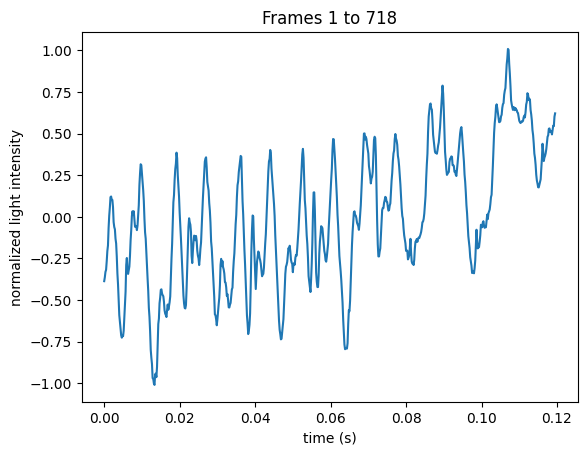

In [5]:
# Step 3: Calculate time and light intensity for each frame

# create seconds_list which will be used for the x axis
seconds_list = [i/SAMPLE_RATE for i in range(LAST_FRAME_NUM)]

# create intensity_list which will be used for the y axis
intensity_list = bf.calc_intensity_time_series(FRAMES_DIR, FIRST_FRAME_NUM, LAST_FRAME_NUM)

# plot results
bf.plt.plot(seconds_list, intensity_list)
bf.plt.title(f"Frames {FIRST_FRAME_NUM} to {LAST_FRAME_NUM}")
bf.plt.xlabel("time (s)")
bf.plt.ylabel("normalized light intensity")

# Create WAV file, save it and provide an audio player
bf.create_wav_file(filename='intensity_timeseries.wav', data=intensity_list, framerate=SAMPLE_RATE)
bf.Audio('intensity_timeseries.wav')

<audio src='intensity_timeseries.wav'></audio>

In [6]:
# Step 4: Make a video to visualize the relationship between an image sequence and the wingbeat waveform

# Create a video from the frames
if bf.os.path.exists('myanimation.mp4'):
    print('myanination.mp4 already exists')
    pass
else:
    fourcc_mp4 = cv2.VideoWriter_fourcc(*'mp4v')    
    video = bf.cv2.VideoWriter(
        filename='myanimation.mp4', 
        fourcc=fourcc_mp4,
        fps=20, 
        frameSize=(600,600))
    for frame_num in range(FIRST_FRAME_NUM, LAST_FRAME_NUM + 1):
        bf.create_frame_intensity_figure(
            frame_num,
            seconds_list, 
            intensity_list, 
            frame_path = f'{FRAMES_DIR}/{frame_num:04d}.png', 
            fig_path = 'figure.png'
            )
        img = bf.cv2.imread('figure.png')
        video.write(img)
    video.release() 
    
# Provide a video player
# FAILS: PROBABLY DUE TO CODEC ISSUES
bf.Video('myanimation.mp4')

myanination.mp4 already exists


# Wingbeat frequency deterimination

### Apply a bandpass filter
We use a Butterworth bandpass filter to suppress frequencies below LOWCUT and greater than HIGHCUT.

In [7]:
LOWCUT = 30
HIGHCUT = 2000
filtered_data = bf.butter_bandpass_filter(data=intensity_list, lowcut=LOWCUT, highcut=HIGHCUT, fs=SAMPLE_RATE, order=6)

### Apply a window
We use a Hanning window to taper the amplitude to zero at both ends.

In [8]:
windowed_filtered_data = bf.np.hanning(len(filtered_data)) * filtered_data

Let's have a look at the conditioned signal.

ic| samplerate: 6000
ic| data.shape: (718,)


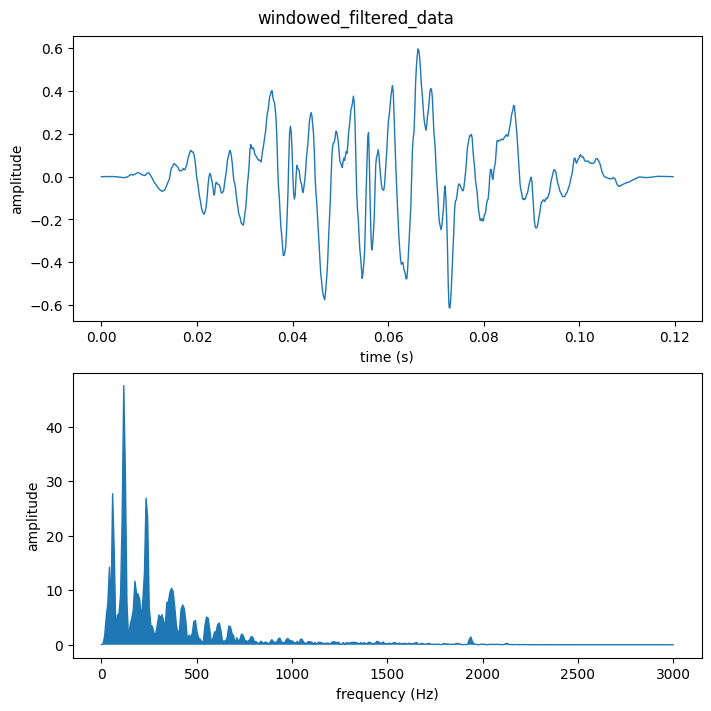

In [9]:
# Plot the conditioned signal
fig, (axt, axf) = bf.plot_time_frequency(SAMPLE_RATE, windowed_filtered_data)
# axf.set_xlim(0, 1000)
# axf.vlines(x=[wbf])
fig.suptitle('windowed_filtered_data')

# Create WAV file, save it and provide an audio player
bf.create_wav_file(filename='windowed_filtered_data.wav', data=windowed_filtered_data, framerate=SAMPLE_RATE)
bf.Audio('windowed_filtered_data.wav')

### Finding the wingbeat frequency and harmonics

In [10]:
# Estimate the wingbeat frequency from the conditioned signal
wbf = bf.freq_from_autocorr(windowed_filtered_data, SAMPLE_RATE)
bf.ic(wbf) 

# Calculate the first 10 harmonic frequencies
harmonic_frequencies = [i * wbf for i in range(1, 11)]
bf.ic(harmonic_frequencies);   

ic| wbf: np.float64(59.947328461747055)
ic| harmonic_frequencies: [np.float64(59.947328461747055),
                           np.float64(119.89465692349411),
                           np.float64(179.84198538524117),
                           np.float64(239.78931384698822),
                           np.float64(299.73664230873527),
                           np.float64(359.68397077048235),
                           np.float64(419.63129923222937),
                           np.float64(479.57862769397644),
                           np.float64(539.5259561557235),
                           np.float64(599.4732846174705)]


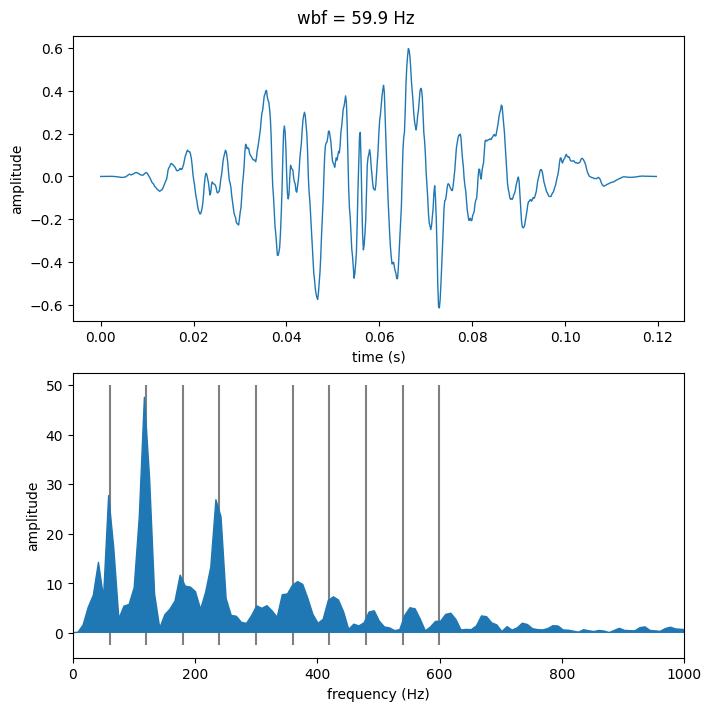

In [11]:
# Modify the figure to show the first 10 harmonic frequencies

# Limit the frequency range to 1000 Hz
axf.set_xlim(0, 1000)

# Set the zorder of the harmonic frequency lines to 0 so that the will be behind the spectrogram (zorder=1)
axf.set_zorder(1)
ymin, ymax = axf.get_ylim()
axf.vlines(x=harmonic_frequencies, ymin=ymin, ymax=ymax, color='gray', zorder=0)

# Display the wingbeat frequency in the title
fig.suptitle(f'wbf = {wbf:.1f} Hz')
fig

### Finished

```
ffmpeg -r 20 -s 1080x1920 -i frames/%04d.png -vcodec libx264 -crf 25 myoutput.mp4
```

In [1]:
import ffmpeg